# BGA2 Paper

Author: Zeming

Date: 01. Aug. 2022

# Import

In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from skimage import io
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from joblib import dump, load

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Global Variable

In [ ]:
# paths img
PATH_TRAINING_IMG = './GTSRB/Final_Training/Images'
PATH_TEST_IMG = './GTSRB/Final_Test/Images'
PATH_TEST_LABELS = os.path.join(PATH_TEST_IMG,'GT-final_test.csv')
assert os.path.exists(PATH_TRAINING_IMG), "Can not find the path."
assert os.path.exists(PATH_TEST_IMG), "Can not find the path."
assert os.path.exists(PATH_TEST_LABELS), "Can not find the path."

# paths HOG
PATH_TRAINING_HOG = './GTSRB/Final_Training/HOG/HOG_01'
PATH_TEST_HOG = './GTSRB/Final_Test/HOG/HOG_01'
assert os.path.exists(PATH_TRAINING_HOG), "Can not find the path."
assert os.path.exists(PATH_TEST_HOG), "Can not find the path."

# # paths haar like features
# PATH_TRAINING_HAAR = './GTSRB/Final_Training/Haar'
# PATH_TEST_HAAR = './GTSRB/Final_Test/Haar'
# assert os.path.exists(PATH_TRAINING_HAAR), "Can not find the path."
# assert os.path.exists(PATH_TEST_HAAR), "Can not find the path."

In [ ]:
# parameters
NUM_CLASSES = 43
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 32

# Data preparation

## Training data

In [ ]:
data_gen_train = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = data_gen_train.flow_from_directory(PATH_TRAINING_IMG, target_size=(64, 64),
                                                classes=None, seed=1,
                                                batch_size=64, subset='training')
valid_data = data_gen_train.flow_from_directory(PATH_TRAINING_IMG, target_size=(64, 64),
                                                classes=None, seed=1,
                                                batch_size=64, subset='validation')

## Test data

In [ ]:
data_gen_test = ImageDataGenerator(rescale=1./255)

In [ ]:
pd_test_data = pd.read_csv(PATH_TEST_LABELS, sep=';', dtype=str)
pd_test_data['ClassId'] = pd_test_data['ClassId'].str.zfill(2)
pd_test_data.head()

In [ ]:
test_data = data_gen_test.flow_from_dataframe(pd_test_data, directory=PATH_TEST_IMG,
                                              x_col='Filename',y_col='ClassId',
                                              classes=None, seed=1,
                                              target_size=(64, 64), shuffle=False)

In [ ]:
print(len(test_data[0]))
X,Y=test_data[0]
print(X.shape)
print(Y.shape,Y[0])

# CNN

In [ ]:
# adding layers
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=(64, 64, 3)))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES))
model.add(layers.Activation('softmax'))

In [ ]:
# compile
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data, epochs=10, validation_data=valid_data)

In [ ]:
history.history
pd.DataFrame.from_dict(history.history).to_csv('csv/cnn_history.csv', index = False, header=True)

In [ ]:
results = model.evaluate(test_data)
results

In [ ]:
model.save('models/cnn.h5')

# Data for classic ML models

In [ ]:
def build_train_datasets(path_to_data_folder, suffix='txt'):
    '''
    Liest die Daten aus dem vorgegebenen Datenordner ein und teilt sie in train- und test-Datensaetze auf
    '''
    if suffix != 'txt' and suffix != 'ppm':
        print ("Abbruch der Funktion: Suffix nicht zutreffend. gueltige Suffixes sind txt oder ppm")
        return

    data = []
    ppm_data = []
    data_labels = []
    subfolders_list = os.listdir(path_to_data_folder)
    # considered_subfolders = [subfolder for subfolder in subfolders_list if int(subfolder) in CONSIDERED_CLASS_IDs]

    for subfolder in subfolders_list:
    # for subfolder in considered_subfolders:
        path_to_considered_datafolder = os.path.join(path_to_data_folder, subfolder)
        for filepath in os.listdir(path_to_considered_datafolder):
            # Final Training knn Features of GTSRB-Images
            if filepath.endswith(suffix):
                full_filepath = os.path.join(path_to_data_folder, subfolder, filepath)
                assert os.path.exists(full_filepath), "Der angegebene Pfad existriert nicht."
                if suffix == 'txt':
                    with open(full_filepath, "r") as text_file:
                        txt_lines = text_file.read().split('\n')
                        txt_lines = [float(x) for x in txt_lines]
                        data.append(txt_lines)
                        data_labels.append(int(subfolder))
                else:
                    ppm_file = io.imread(full_filepath)
                    ppm_file_resized = resize(ppm_file, (64, 64), anti_aliasing=True)
                    data.append(ppm_file_resized)
                    data_labels.append(int(subfolder))


    data = np.array(data, dtype=np.float32)
    data_labels = np.array(data_labels)

    # X_train, X_val, y_tain, y_val = train_test_split(data,data_labels, test_size=0.2, random_state=42)
    return data, data_labels

def build_test_datasets(path_to_data_folder, suffix='txt'):
    '''
    Liest die Daten aus dem vorgegebenen Datenordner ein und teilt sie in train- und test-Datensaetze auf
    '''
    if suffix != 'txt' and suffix != 'ppm':
        print ("Abbruch der Funktion: Suffix nicht zutreffend. gueltige Suffixes sind txt oder ppm")
        return

    data = []
    ppm_data = []
    files_list = os.listdir(path_to_data_folder)
    # considered_subfolders = [subfolder for subfolder in subfolders_list if int(subfolder) in CONSIDERED_CLASS_IDs]

    # for subfolder in subfolders_list:

    full_files_list = [os.path.join(path_to_data_folder, a) for a in files_list]
    for filepath in full_files_list:
        # Final Training HOG Features of GTSRB-Images
        if filepath.endswith(suffix):
            assert os.path.exists(filepath), "Der angegebene Pfad existriert nicht."
            if suffix == 'txt':
                with open(filepath, "r") as text_file:
                    txt_lines = text_file.read().split('\n')
                    txt_lines = [float(x) for x in txt_lines]
                    data.append(txt_lines)
            else:
                ppm_file = io.imread(filepath)
                ppm_file_resized = resize(ppm_file, (64, 64), anti_aliasing=True)
                data.append(ppm_file_resized)


    data = np.array(data, dtype=np.float32)

    # X_train, X_val, y_tain, y_val = train_test_split(data,data_labels, test_size=0.2, random_state=42)
    return data

## HOG

In [ ]:
# read HOG features
X_train_hog, y_train_hog = build_train_datasets(PATH_TRAINING_HOG,'txt')
X_test_hog = build_test_datasets(PATH_TEST_HOG,'txt')

pd_test_data = pd.read_csv(PATH_TEST_LABELS, sep=';', dtype=str)
pd_test_data['ClassId'] = pd_test_data['ClassId'].str.zfill(2)
y_test_hog = pd_test_data['ClassId'].to_numpy().astype(int)

### HOG + SVM

In [ ]:
# scaler = StandardScaler()
# X_train_hog = scaler.fit_transform(X_train_hog)
svm_hog = SVC(probability=True)
svm_hog.fit(X_train_hog, y_train_hog)
dump(svm_hog, './models/svm_hog.pkl')

### HOG + K-NN

In [ ]:
# scaler = StandardScaler()
# X_train_hog = scaler.fit_transform(X_train_hog)
knn_hog = KNeighborsClassifier(n_neighbors= 20)
knn_hog.fit(X_train_hog, y_train_hog)
dump(knn_hog, './models/knn_hog.pkl')

### HOG + random forest

In [ ]:
rf_hog = RandomForestClassifier()
rf_hog.fit(X_train_hog, y_train_hog)
dump(rf_hog, './models/rf_hog.pkl')

# Plot PR-curve

## Load models

In [ ]:
# sklearn models
svm = load('./models/svm_hog.pkl')
knn = load('./models/knn_hog.pkl')
rf = load('./models/rf_hog.pkl')

# keras model
cnn = models.load_model('./models/cnn.h5')

## Load test data

In [ ]:
# Images
X_test_img = build_test_datasets(PATH_TEST_IMG,'ppm')

# HOG
X_test_hog = build_test_datasets(PATH_TEST_HOG,'txt')

pd_test_data = pd.read_csv(PATH_TEST_LABELS, sep=';', dtype=str)
pd_test_data['ClassId'] = pd_test_data['ClassId'].str.zfill(2)
y_test = pd_test_data['ClassId'].to_numpy().astype(int)

## Predict score
get predict scores for each category with different model and save it

In [ ]:
# get predict scores and save them
y_score_cnn = cnn.predict_proba(X_test_img)
y_score_svm = svm.predict_proba(X_test_hog)
y_score_knn = knn.predict_proba(X_test_hog)
y_score_rf = rf.predict_proba(X_test_hog)

scores = [y_score_cnn, y_score_svm, y_score_knn, y_score_rf]
f = open('./scores/scores.pickle', 'wb')
pickle.dump(scores,f)
f.close()

In [ ]:
# load scores
f = open('./scores/scores.pickle', 'rb')
# scores = pickle.load(f)
scores = pickle.load(f)
# y_score_cnn, y_score_svm, y_score_knn, y_score_rf = pickle.load(f)
f.close()

In [ ]:
def plot_multi_pr_curve(scores, model_list, y_labels, n_classes):

        precision_list = []
        recall_list = []
        average_precision_list = []
        
        for y_score, model in zip(scores, model_list):
                
                y_labels = label_binarize(y_test, classes=np.arange(0,n_classes))

                # For each class
                precision = dict()
                recall = dict()
                average_precision = dict()

                for i in range(n_classes):
                        precision[i], recall[i], _ = precision_recall_curve(y_labels[:, i], y_score[:, i])
                        average_precision[i] = average_precision_score(y_labels[:, i], y_score[:, i])

                # A "micro-average": quantifying score on all classes jointly
                precision['micro'], recall['micro'], _ = precision_recall_curve(y_labels.ravel(), y_score.ravel())
                average_precision['micro'] = average_precision_score(y_labels, y_score, average="micro")
                print(f'Model: {model}')
                print('Average precision score, micro-averaged over all classes: {0:0.2f}. \n'.format(average_precision["micro"]))

                precision_list.append(precision)
                recall_list.append(recall)
                average_precision_list.append(average_precision)
                
        plt.figure(figsize=(8, 6), dpi= 200)
        
        for model, precision, recall,average_precision in zip(model_list, precision_list, recall_list, average_precision_list):
                
                plt.step(recall['micro'], precision['micro'], where='post', 
                         label = f'{model}: Micro-average Precision-Recall (AP = {average_precision["micro"]:0.2f})')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.ylim([0.0, 1.05])
                plt.xlim([0.0, 1.0])
                plt.title('Micro-average Precision-Recall of Multi-Classifiers')
        
        plt.legend(loc=(0, -0.35))
        plt.show()


model_names = ['ConvNet', 'SVM', 'K-Nearest Neighbors', 'Random Forest']
plot_multi_pr_curve(scores, model_names, y_test, NUM_CLASSES)

# Confusion Matrix

## Load Models

In [ ]:
# sklearn models
svm = load('./models/svm_hog.pkl')
knn = load('./models/knn_hog.pkl')
rf = load('./models/rf_hog.pkl')

# keras model
cnn = models.load_model('./models/cnn.h5')

## Load Test Data 

In [ ]:
# Images
X_test_img = build_test_datasets(PATH_TEST_IMG,'ppm')

# HOG
X_test_hog = build_test_datasets(PATH_TEST_HOG,'txt')

pd_test_data = pd.read_csv(PATH_TEST_LABELS, sep=';', dtype=str)
pd_test_data['ClassId'] = pd_test_data['ClassId'].str.zfill(2)
y_test = pd_test_data['ClassId'].to_numpy().astype(int)

## Predict

In [ ]:
y_pred_cnn = cnn.predict_classes(X_test_img)

In [ ]:
y_pred_svm = svm.predict(X_test_hog)

In [ ]:
y_pred_knn = knn.predict(X_test_hog)

In [ ]:
y_pred_rf = rf.predict(X_test_hog)

In [ ]:
pred_list = [y_pred_cnn, y_pred_svm, y_pred_knn, y_pred_rf]
f = open('./scores/pred.pickle', 'wb')
pickle.dump(pred_list,f)
f.close()

In [ ]:
# load scores
f = open('./scores/pred.pickle', 'rb')
# scores = pickle.load(f)
pred_list = pickle.load(f)
# y_score_cnn, y_score_svm, y_score_knn, y_score_rf = pickle.load(f)
f.close()

In [ ]:
# Classification Report
print(classification_report(y_test, y_pred_cnn))

In [ ]:
print(classification_report(y_test, y_pred_svm))

In [ ]:
print(classification_report(y_test, y_pred_knn))

In [ ]:
print(classification_report(y_test, y_pred_rf))

In [ ]:
model_names = ['ConvNet', 'SVM', 'K-Nearest Neighbors', 'Random Forest']

f1_dict= {}
for model, y_pred in zip(model_names, pred_list):
    micro_f1, macro_f1 = f1_score(y_test, y_pred, average = 'micro'), f1_score(y_test, y_pred, average = 'macro')
    f1_dict[model] = [micro_f1, macro_f1]
f1_df = pd.DataFrame.from_dict(f1_dict, orient='index', columns=['micro f1', 'macro f1'])
f1_df

In [ ]:
def plot_confusion_matrix(conf_matr, model):
    
    plt.figure(figsize=(16,9), dpi=200)
    plt.imshow(conf_matr, interpolation='nearest')
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(NUM_CLASSES)
    plt.xticks(tick_marks, list(np.arange(NUM_CLASSES).astype(str)))
    plt.yticks(tick_marks)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix of {model}')

model_names = ['ConvNet', 'SVM', 'K-Nearest Neighbors', 'Random Forest']

for y_pred, model in zip(pred_list, model_names):
    cm = confusion_matrix(y_true = y_test, y_pred = y_pred, normalize = 'pred')
    plot_confusion_matrix(cm ,model)


Model: ConvNet
Average precision score, micro-averaged over all classes: 0.99. 

Model: SVM
Average precision score, micro-averaged over all classes: 0.98. 

Model: K-Nearest Neighbors
Average precision score, micro-averaged over all classes: 0.83. 

Model: Random Forest
Average precision score, micro-averaged over all classes: 0.97. 



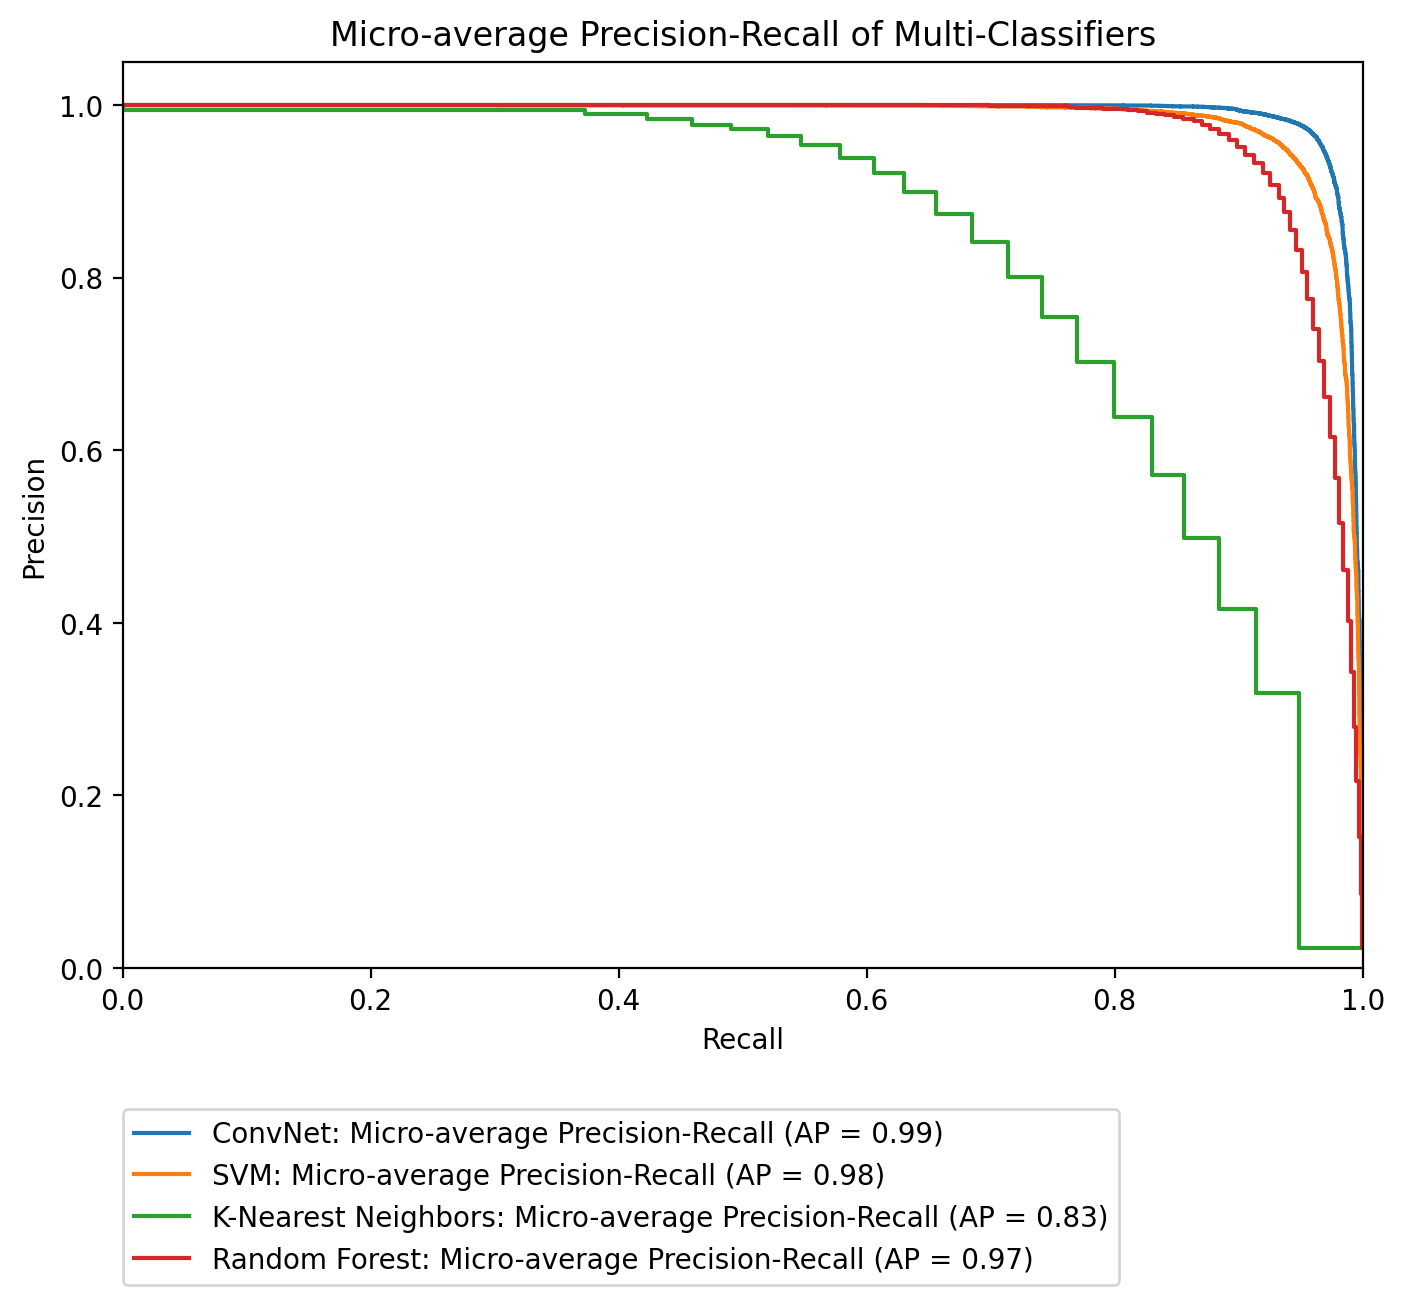

In [51]:
def plot_multi_pr_curve(scores, model_list, y_labels, n_classes):

        precision_list = []
        recall_list = []
        average_precision_list = []
        
        for y_score, model in zip(scores, model_list):
                
                y_labels = label_binarize(y_test, classes=np.arange(0,n_classes))

                # For each class
                precision = dict()
                recall = dict()
                average_precision = dict()

                for i in range(n_classes):
                        precision[i], recall[i], _ = precision_recall_curve(y_labels[:, i], y_score[:, i])
                        average_precision[i] = average_precision_score(y_labels[:, i], y_score[:, i])

                # A "micro-average": quantifying score on all classes jointly
                precision['micro'], recall['micro'], _ = precision_recall_curve(y_labels.ravel(), y_score.ravel())
                average_precision['micro'] = average_precision_score(y_labels, y_score, average="micro")
                print(f'Model: {model}')
                print('Average precision score, micro-averaged over all classes: {0:0.2f}. \n'.format(average_precision["micro"]))

                precision_list.append(precision)
                recall_list.append(recall)
                average_precision_list.append(average_precision)
                
        plt.figure(figsize=(8, 6), dpi= 200)
        
        for model, precision, recall,average_precision in zip(model_list, precision_list, recall_list, average_precision_list):
                
                plt.step(recall['micro'], precision['micro'], where='post', 
                         label = f'{model}: Micro-average Precision-Recall (AP = {average_precision["micro"]:0.2f})')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.ylim([0.0, 1.05])
                plt.xlim([0.0, 1.0])
                plt.title('Micro-average Precision-Recall of Multi-Classifiers')
        
        plt.legend(loc=(0, -0.35))
        plt.show()


model_names = ['ConvNet', 'SVM', 'K-Nearest Neighbors', 'Random Forest']
plot_multi_pr_curve(scores, model_names, y_test, NUM_CLASSES)

# Confusion Matrix

## Load Models

In [5]:
# sklearn models
svm = load('./models/svm_hog.pkl')
knn = load('./models/knn_hog.pkl')
rf = load('./models/rf_hog.pkl')

# keras model
cnn = models.load_model('./models/cnn.h5')

## Load Test Data 

In [9]:
# Images
X_test_img = build_test_datasets(PATH_TEST_IMG,'ppm')

# HOG
X_test_hog = build_test_datasets(PATH_TEST_HOG,'txt')

pd_test_data = pd.read_csv(PATH_TEST_LABELS, sep=';', dtype=str)
pd_test_data['ClassId'] = pd_test_data['ClassId'].str.zfill(2)
y_test = pd_test_data['ClassId'].to_numpy().astype(int)

## Predict

In [32]:
y_pred_cnn = cnn.predict_classes(X_test_img)

In [33]:
y_pred_svm = svm.predict(X_test_hog)

In [34]:
y_pred_knn = knn.predict(X_test_hog)

In [35]:
y_pred_rf = rf.predict(X_test_hog)

In [37]:
pred_list = [y_pred_cnn, y_pred_svm, y_pred_knn, y_pred_rf]
f = open('./scores/pred.pickle', 'wb')
pickle.dump(pred_list,f)
f.close()

In [38]:
# load scores
f = open('./scores/pred.pickle', 'rb')
# scores = pickle.load(f)
pred_list = pickle.load(f)
# y_score_cnn, y_score_svm, y_score_knn, y_score_rf = pickle.load(f)
f.close()

In [41]:
# Classification Report
print(classification_report(y_test, y_pred_cnn))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90        60
           1       0.96      0.98      0.97       720
           2       0.99      0.97      0.98       750
           3       1.00      0.94      0.97       450
           4       0.98      0.98      0.98       660
           5       0.93      0.97      0.95       630
           6       0.96      0.84      0.90       150
           7       0.98      0.91      0.94       450
           8       0.91      0.94      0.93       450
           9       0.98      0.99      0.99       480
          10       0.98      0.99      0.99       660
          11       0.97      0.99      0.98       420
          12       0.97      0.99      0.98       690
          13       0.95      1.00      0.97       720
          14       1.00      1.00      1.00       270
          15       0.94      1.00      0.97       210
          16       0.99      1.00      1.00       150
          17       1.00    

In [42]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94        60
           1       0.91      0.93      0.92       720
           2       0.86      0.96      0.91       750
           3       0.89      0.83      0.86       450
           4       0.98      0.96      0.97       660
           5       0.86      0.90      0.88       630
           6       0.93      0.76      0.84       150
           7       0.96      0.90      0.93       450
           8       0.90      0.91      0.91       450
           9       0.97      1.00      0.98       480
          10       0.99      0.99      0.99       660
          11       0.90      0.97      0.94       420
          12       1.00      1.00      1.00       690
          13       0.99      1.00      1.00       720
          14       1.00      0.99      0.99       270
          15       1.00      0.99      1.00       210
          16       1.00      0.99      0.99       150
          17       1.00    

In [43]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       1.00      0.33      0.50        60
           1       0.79      0.53      0.63       720
           2       0.73      0.56      0.64       750
           3       0.69      0.54      0.61       450
           4       0.80      0.83      0.81       660
           5       0.41      0.78      0.53       630
           6       0.82      0.74      0.78       150
           7       0.61      0.67      0.64       450
           8       0.60      0.78      0.68       450
           9       0.98      0.79      0.87       480
          10       0.84      0.95      0.89       660
          11       0.74      0.60      0.66       420
          12       1.00      1.00      1.00       690
          13       1.00      1.00      1.00       720
          14       1.00      0.95      0.97       270
          15       1.00      0.88      0.93       210
          16       0.97      0.99      0.98       150
          17       1.00    

In [44]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80        60
           1       0.95      0.88      0.91       720
           2       0.86      0.98      0.91       750
           3       0.94      0.83      0.89       450
           4       0.92      0.96      0.94       660
           5       0.83      0.90      0.86       630
           6       0.82      0.78      0.80       150
           7       0.94      0.92      0.93       450
           8       0.89      0.87      0.88       450
           9       0.93      1.00      0.96       480
          10       0.99      0.99      0.99       660
          11       0.86      0.93      0.89       420
          12       0.99      1.00      1.00       690
          13       0.99      1.00      1.00       720
          14       1.00      0.98      0.99       270
          15       0.99      0.98      0.98       210
          16       1.00      0.98      0.99       150
          17       1.00    

In [59]:
model_names = ['ConvNet', 'SVM', 'K-Nearest Neighbors', 'Random Forest']

f1_dict= {}
for model, y_pred in zip(model_names, pred_list):
    micro_f1, macro_f1 = f1_score(y_test, y_pred, average = 'micro'), f1_score(y_test, y_pred, average = 'macro')
    f1_dict[model] = [micro_f1, macro_f1]
f1_df = pd.DataFrame.from_dict(f1_dict, orient='index', columns=['micro f1', 'macro f1'])
f1_df

,micro f1,macro f1
ConvNet,0.961758,0.946350
SVM,0.943705,0.928923
K-Nearest Neighbors,0.758828,0.725398
Random Forest,0.935075,0.916097


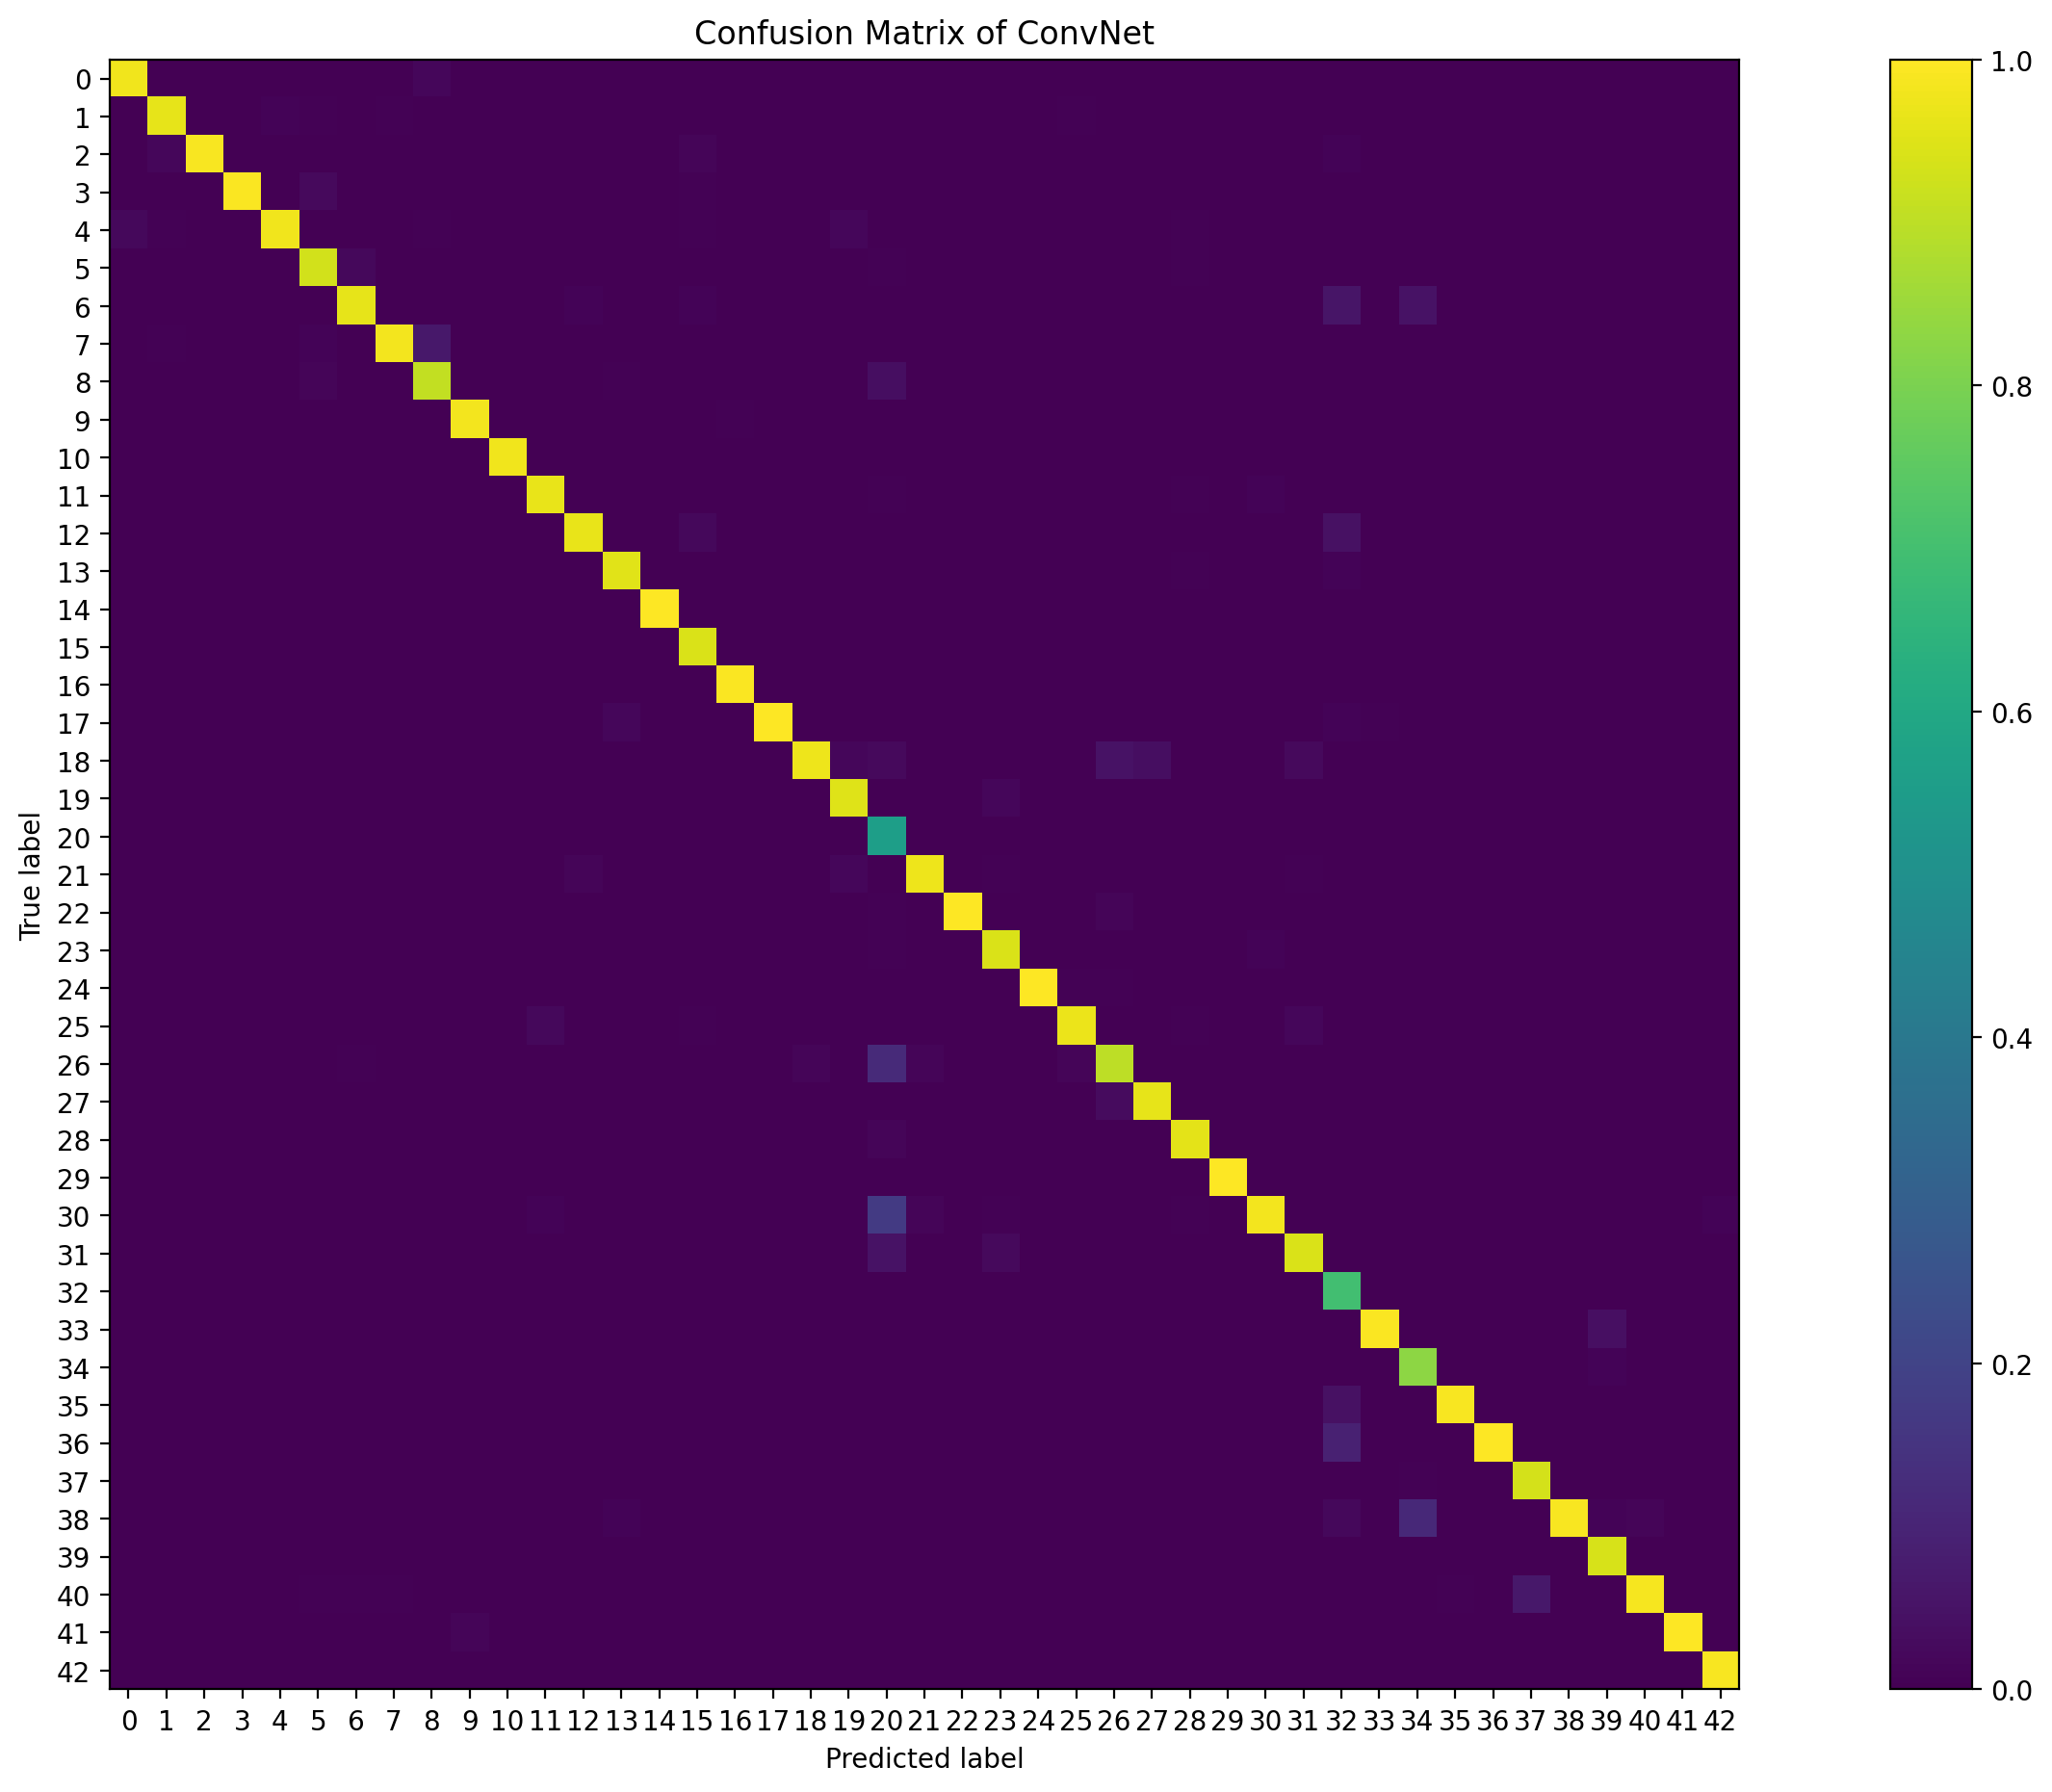

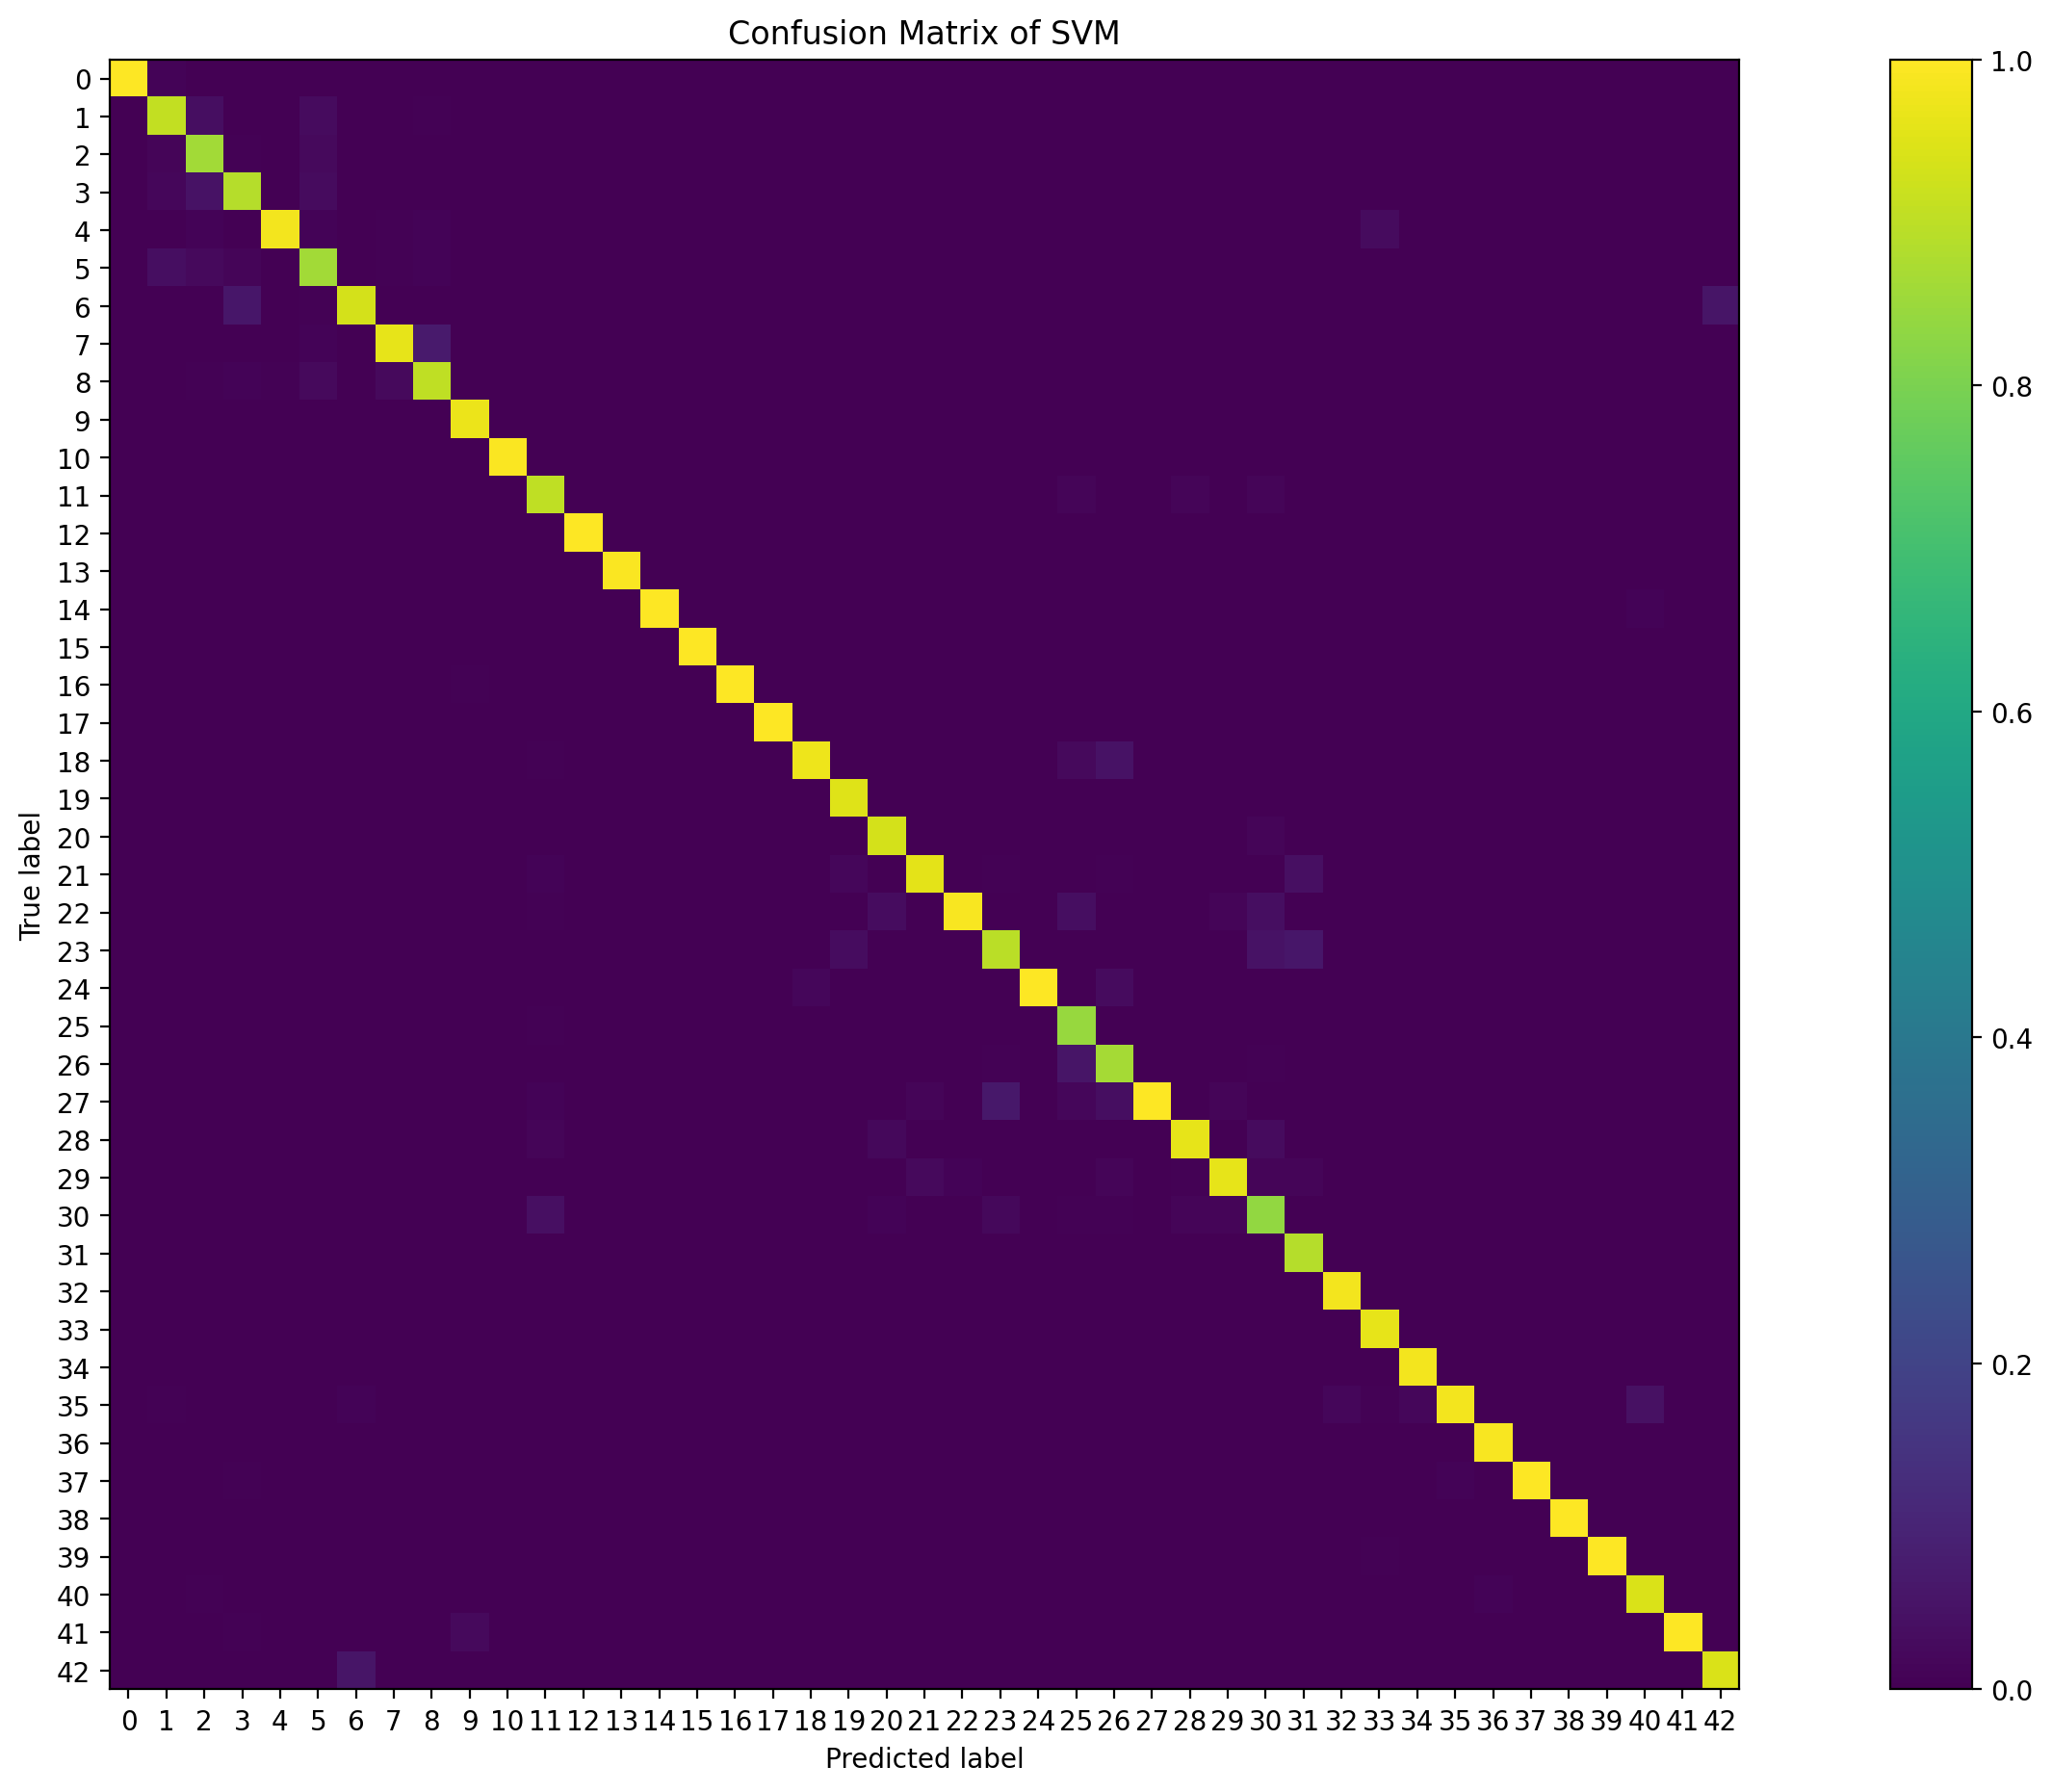

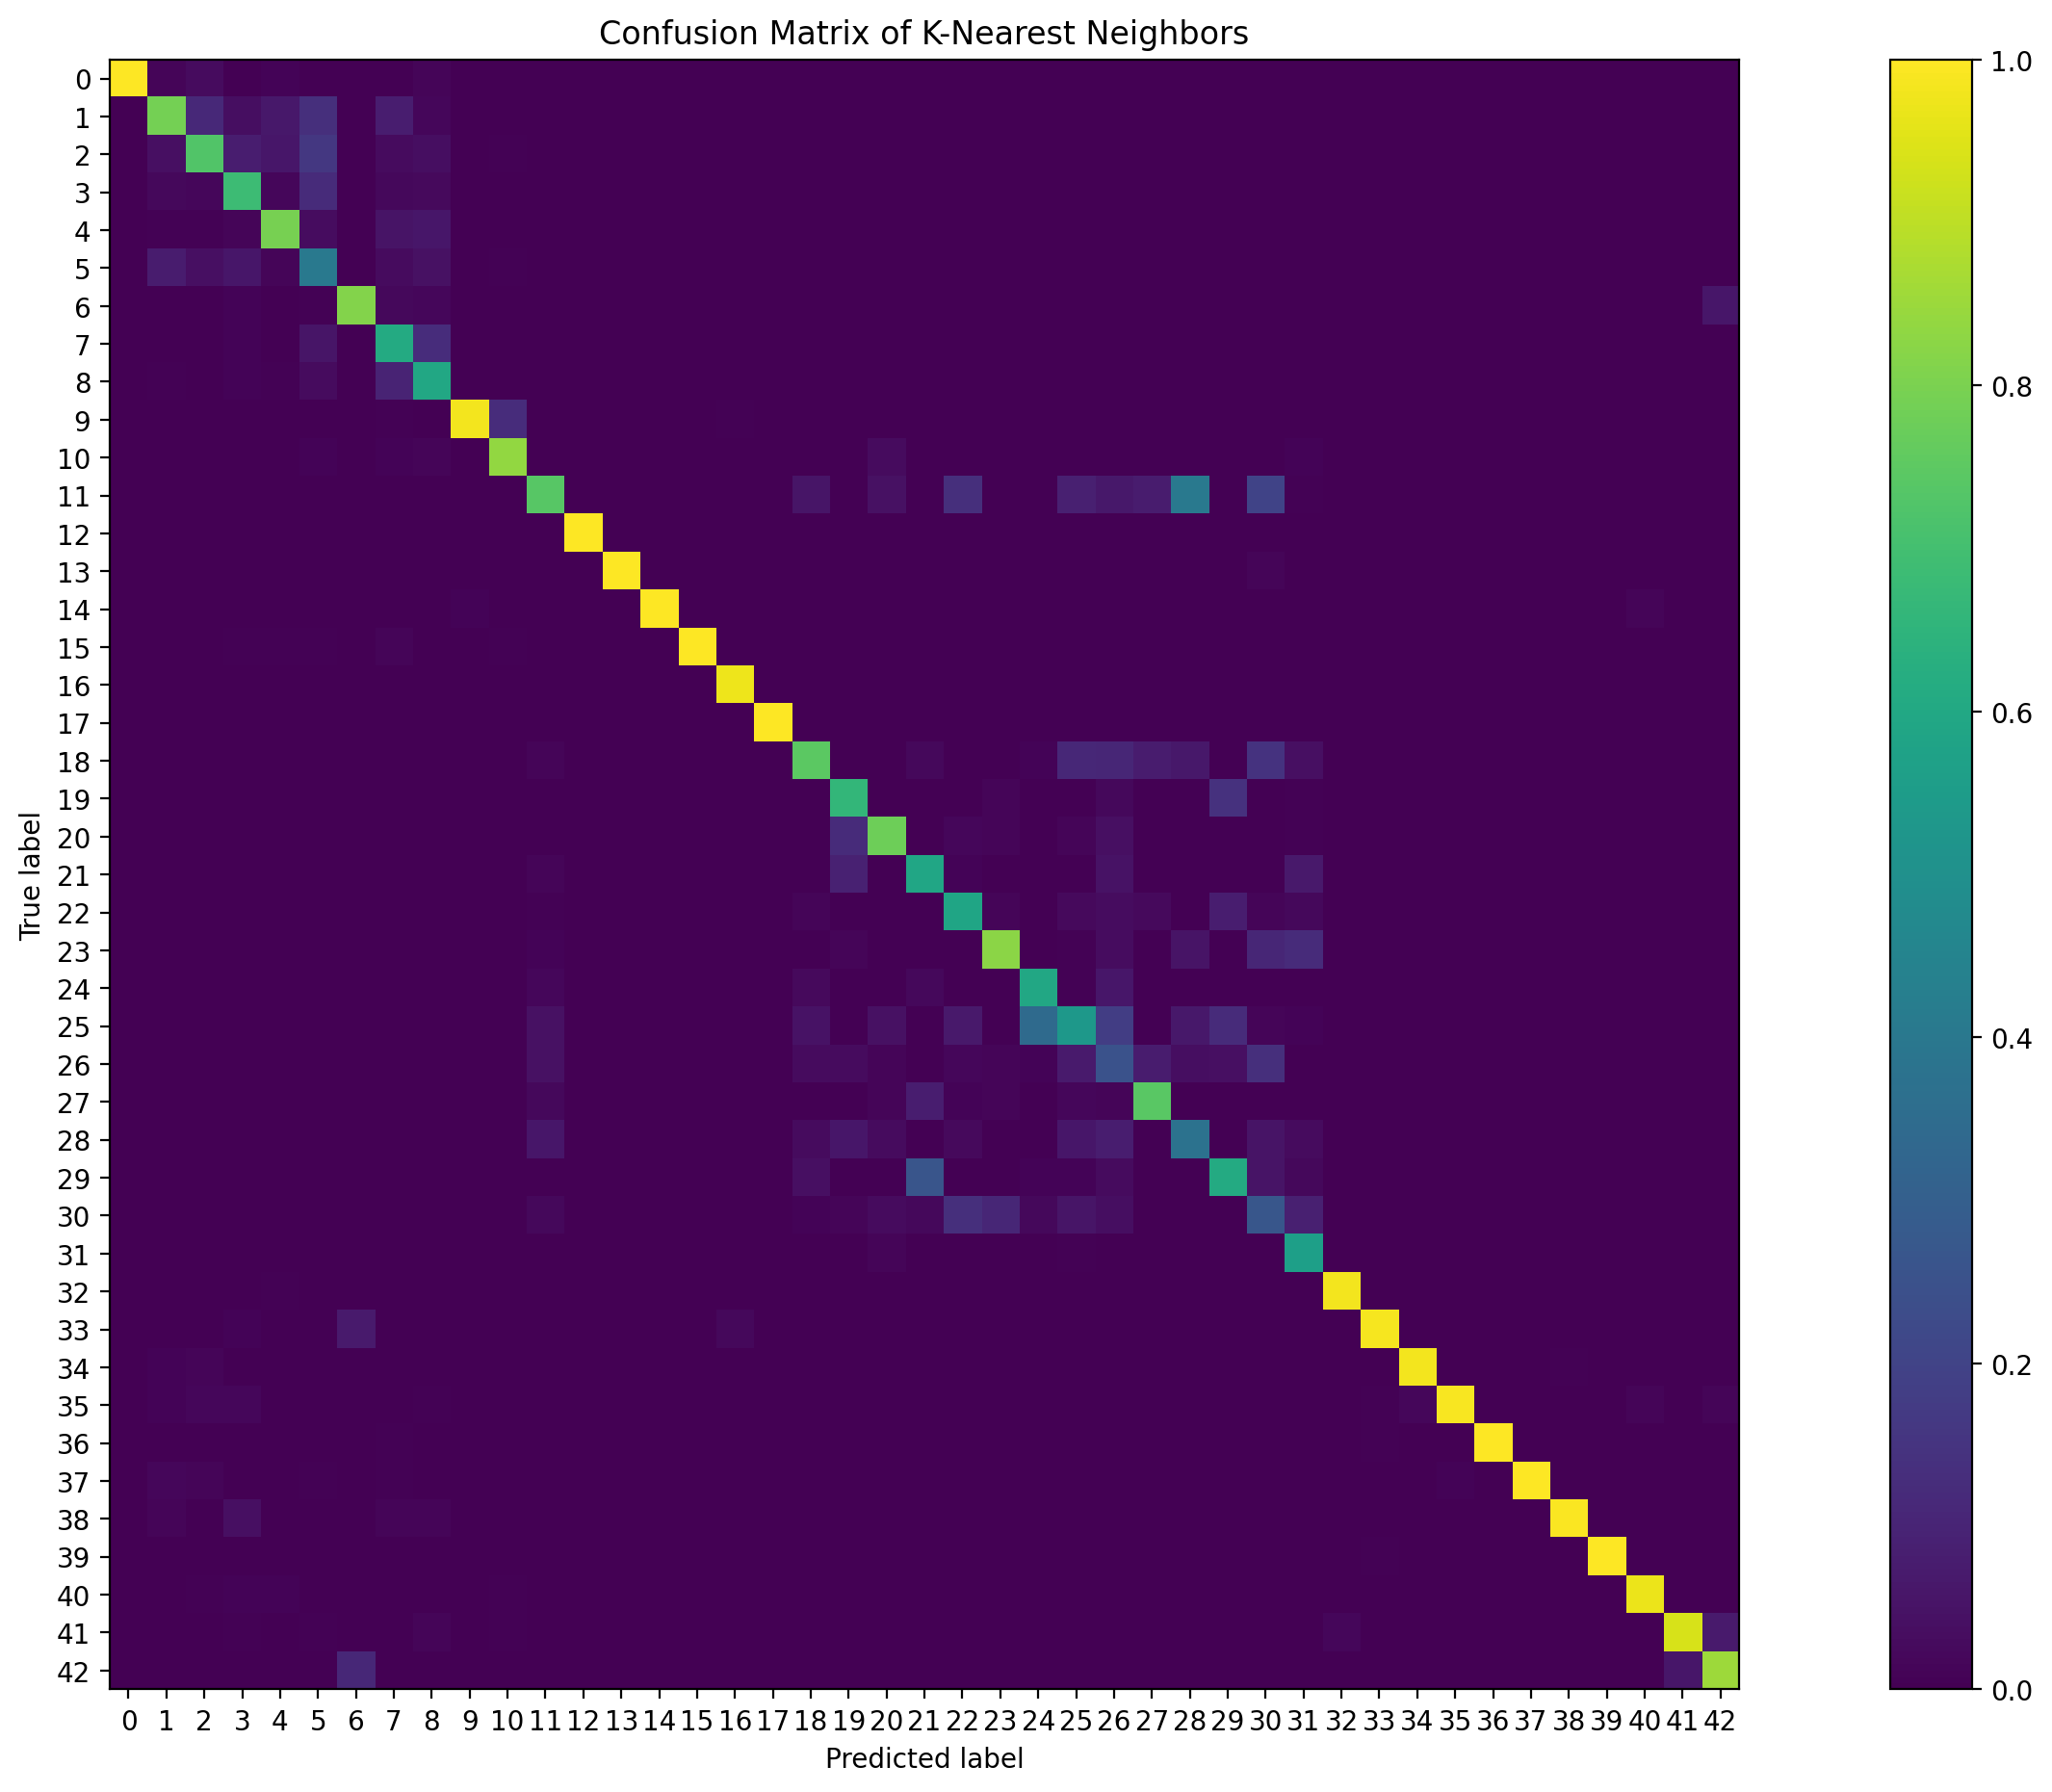

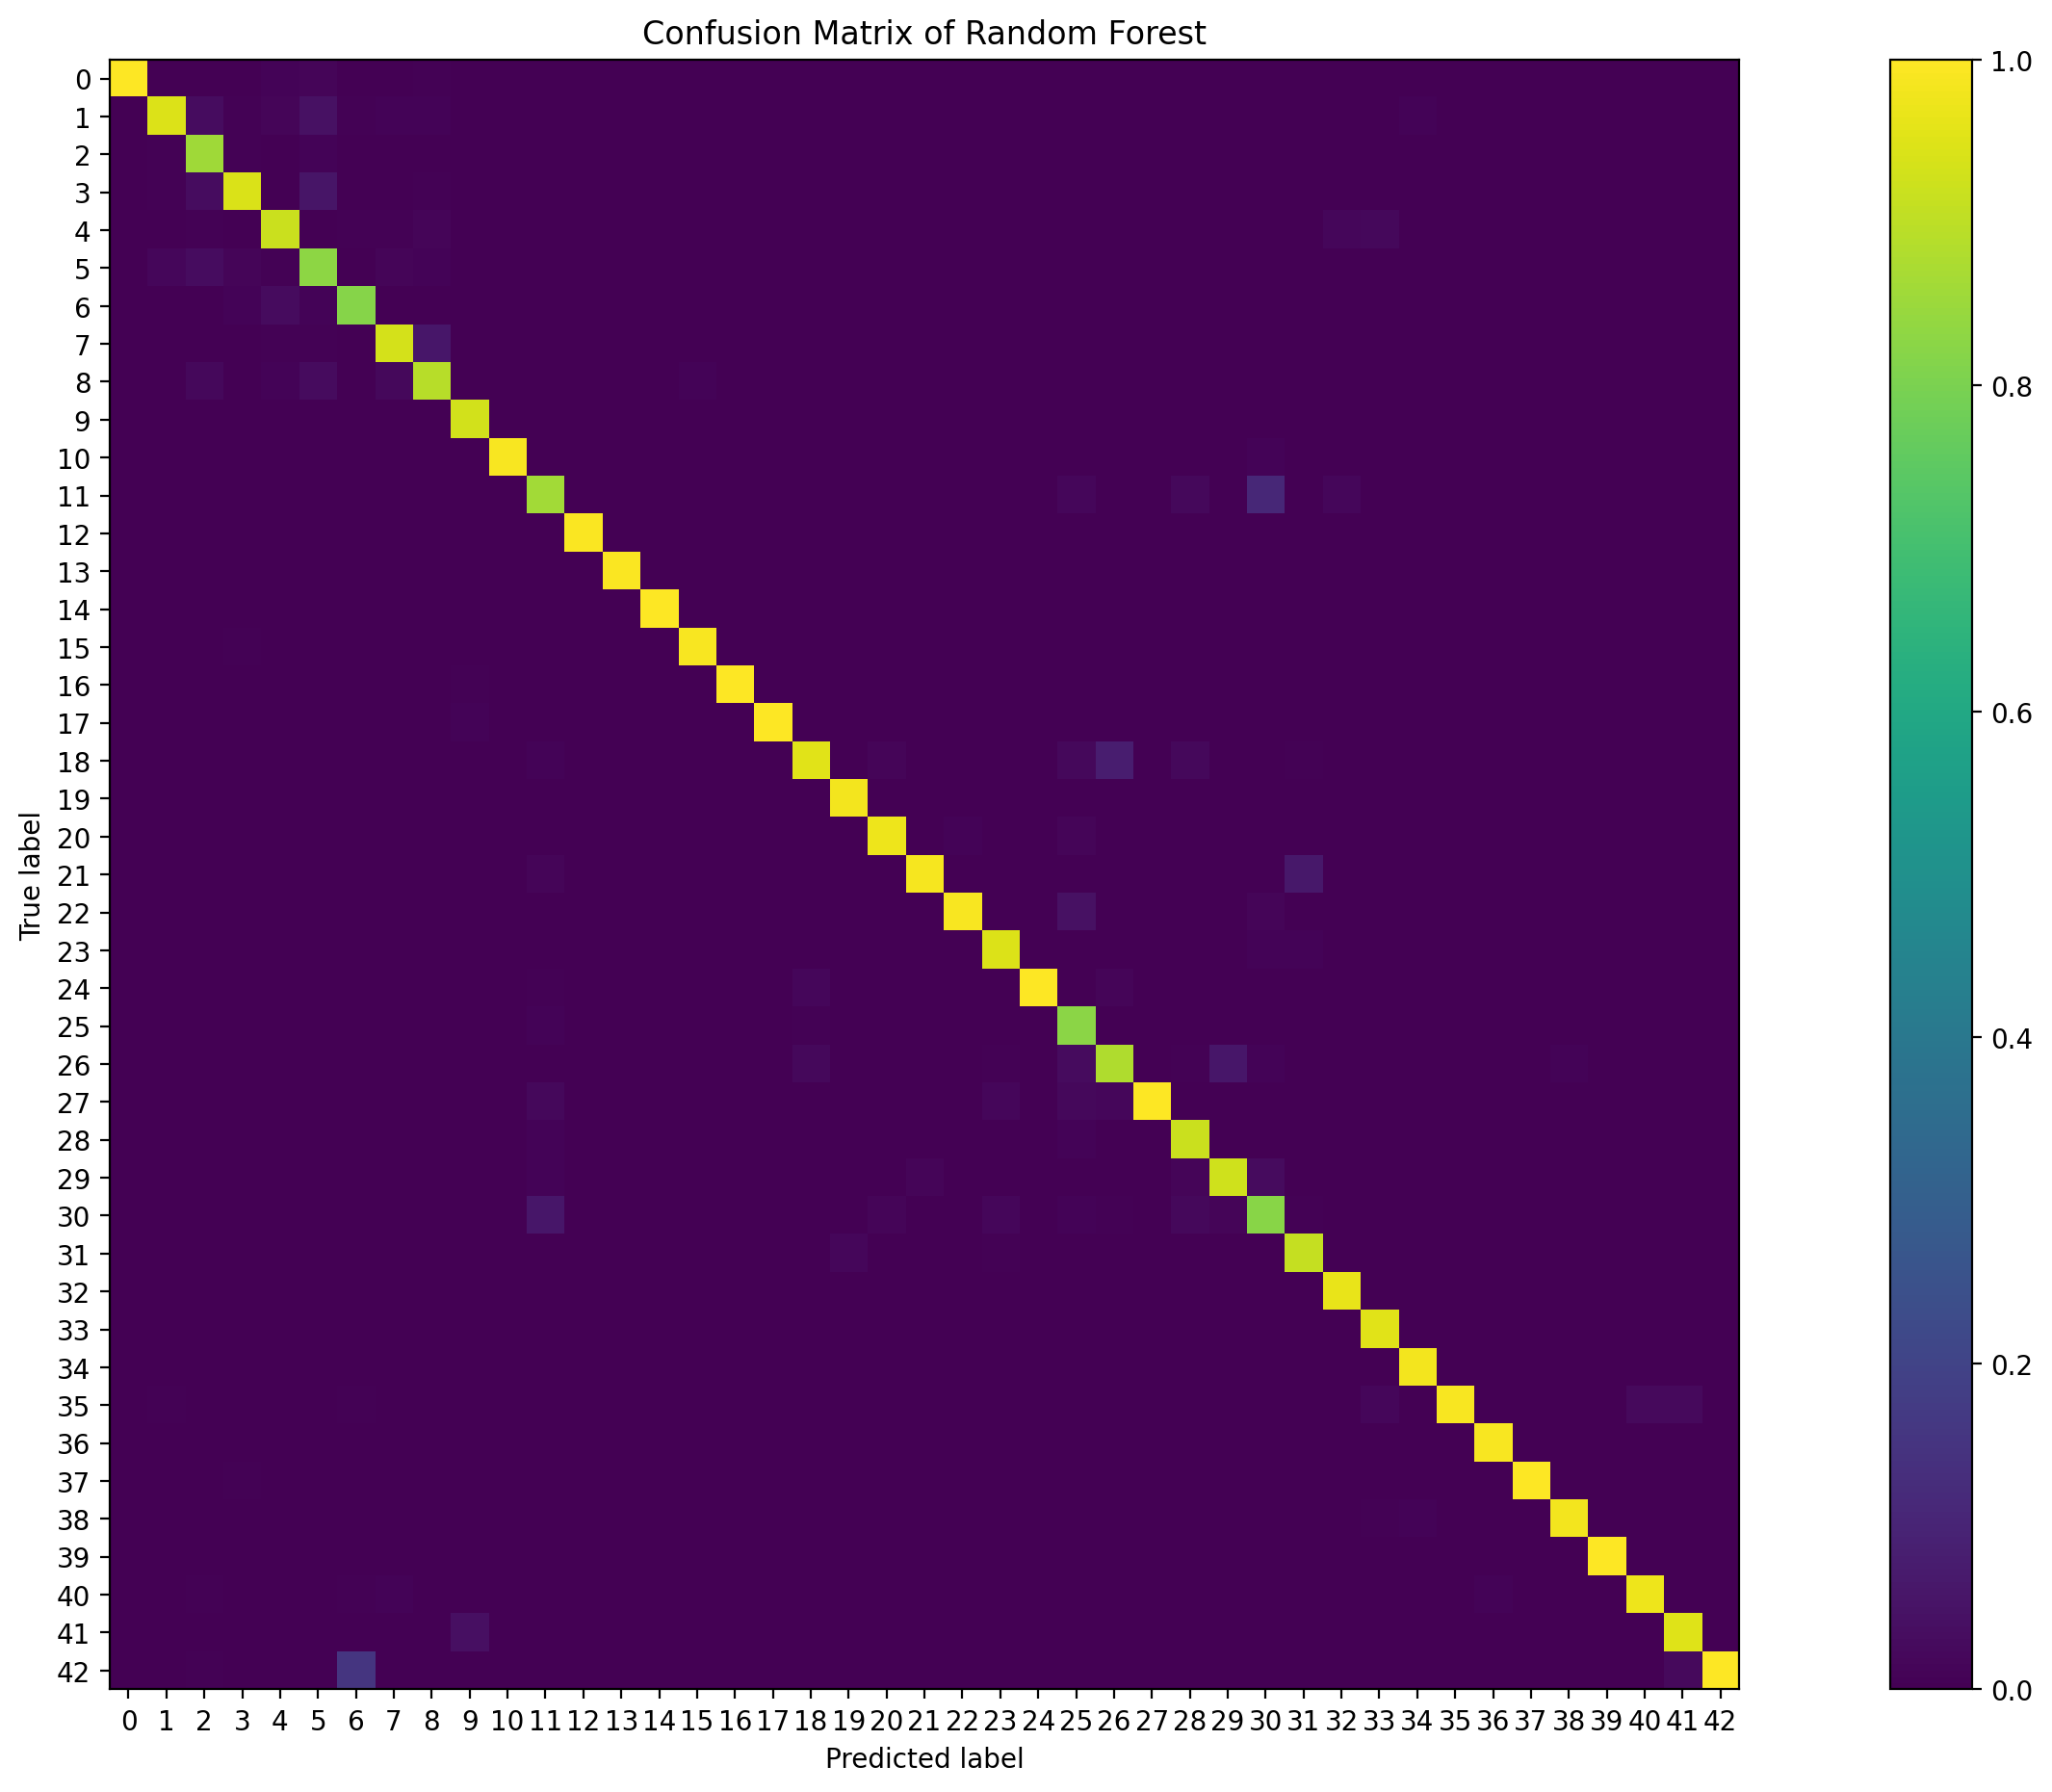

In [45]:
def plot_confusion_matrix(conf_matr, model):
    
    plt.figure(figsize=(16,9), dpi=200)
    plt.imshow(conf_matr, interpolation='nearest')
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(NUM_CLASSES)
    plt.xticks(tick_marks, list(np.arange(NUM_CLASSES).astype(str)))
    plt.yticks(tick_marks)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix of {model}')

model_names = ['ConvNet', 'SVM', 'K-Nearest Neighbors', 'Random Forest']

for y_pred, model in zip(pred_list, model_names):
    cm = confusion_matrix(y_true = y_test, y_pred = y_pred, normalize = 'pred')
    plot_confusion_matrix(cm ,model)
